# Inverse Kinematics Simulation

In [1]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import math
import numpy as np

### Polar coordinate functions

In [2]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

### Calculate end-joint values from xyz position

In [157]:
def normalize_degree(theta):
    # Normalizes degree theta from -1.5pi to 1.5pi
    multiplier = 1
    normalized_theta = theta % (math.pi * multiplier)
    
    # Maintain the negative sign if the original angle is negative
    if theta < 0:
        normalized_theta -= math.pi * multiplier

    # Return angle
    return normalized_theta

def get_joints_from_xyz_rel(x, y, z, initial_guess = (math.pi/2, math.pi/2, 0), limbs=(.422864, .359041, .092124)):
    # Get polar coordinates of x,y pair
    r, theta = cartesian_to_polar(x, y)
    
    # Get length of each limb
    l1, l2, l3 = limbs
    
    # Formulas to find out joint positions for (r, z)
    def inv_kin_r_z(p):
        a, b, c = p

        return (l1*math.cos(a) + l2*math.cos(a-b) + l3*math.cos(a-b-c) - r, # r
                l1*math.sin(a) + l2*math.sin(a-b) - l3*math.sin(a-b-c) - z,  # z
                a-b-c) # wrist angle


    # Normalize angles
    base, shoulder, elbow, wrist = [normalize_degree(deg) for deg in [theta, *fsolve(inv_kin_r_z, initial_guess)]]

    # Return result
    return base, shoulder, elbow, wrist

def get_joints_from_xyz_abs(x, y, z):
    joints = get_joints_from_xyz_rel(x, y, z)

    # Joint offsets
    # Base, Shoulder, Elbow, Wrist
    inverse = [1, -1, 1, 1]
    offsets = [0, 0, 0, -math.pi/2]

    # Return adjusted joint positions
    return [o+j*i for j, o, i in zip(joints, offsets, inverse)]

print([math.degrees(deg) for deg in get_joints_from_xyz_rel(0.3, 0.3, 0.3)])
print([math.degrees(deg) for deg in get_joints_from_xyz_abs(0.3, 0.3, 0.3)])

[45.0, 90.70951422006029, 110.71500355039022, -20.005489330329944]
[45.0, -90.70951422006029, 110.71500355039022, -110.00548933032994]


### Simulate arm and joint angles

Target position (x,y,z): 0.3 0.3 0.3
Angles (base, shoulder, elbow, wrist): [45.0, 90.7095, 110.715, -20.0055]
Robot Angles: [45.0, -90.7095, 110.715, -110.0055]
elbow (x,y): -0.005 0.423
wrist (x,y): 0.332 0.3
tool  (x,y): 0.424 0.3


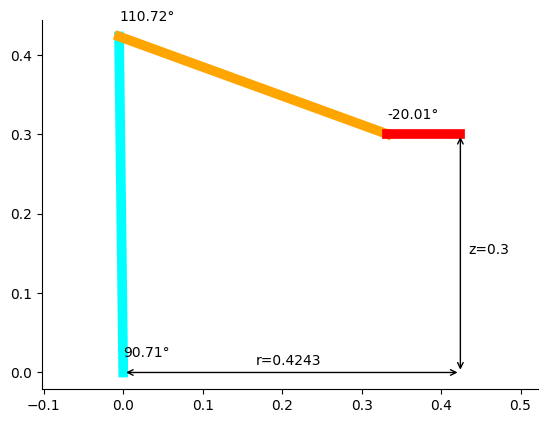

In [164]:
def draw_arm(x, y, z):

    # Get joint angles
    l1, l2, l3 = (.422864, .359041, .092124)
    r, theta = cartesian_to_polar(x, y)
    base, shoulder, elbow, wrist = get_joints_from_xyz_rel(x, y, z)

    # Print angles
    print('Target position (x,y,z):', x, y, z)
    print('Angles (base, shoulder, elbow, wrist):', [round(math.degrees(i), 4) for i in [base, shoulder, elbow, wrist]])
    print('Robot Angles:', [round(math.degrees(i), 4) for i in get_joints_from_xyz_abs(x, y, z)])

    # Calculate each joint's endpoint position
    x1, y1 = polar_to_cartesian(l1, shoulder)
    x2, y2 = polar_to_cartesian(l2, shoulder-elbow)
    x2 += x1
    y2 += y1
    x3, y3 = polar_to_cartesian(l3, shoulder-elbow-wrist)
    x3 += x2
    y3 += y2

    # Print each joint's endpoint position
    print('elbow (x,y):', round(x1,3), round(y1,3))
    print('wrist (x,y):', round(x2,3), round(y2,3))
    print('tool  (x,y):', round(x3,3), round(y3,3))

    # Draw limbs
    plt.plot([0, x1], [0, y1], color='cyan', linewidth=7)
    plt.plot([x1, x2], [y1, y2], color='orange', linewidth=7)
    plt.plot([x2, x2+l3], [y2, y2], color='red', linewidth=7)

    # Display angles
    plt.text(0, 0.02, f'{round(math.degrees(shoulder), 2)}°')
    plt.text(x1, y1+0.02, f'{round(math.degrees(elbow), 2)}°')
    plt.text(x2, y2+0.02, f'{round(math.degrees(wrist), 2)}°')

    # Display r arrow
    plt.annotate(f'', xy=(0, 0), xycoords='data', xytext=(x3, 0), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'r={round(r,4)}', xy=(x2/2, 0.01), xycoords='data', xytext=(x2/2, 0), textcoords='offset points')

    # Display z arrow
    plt.annotate(f'', xy=(x3, 0), xycoords='data', xytext=(x3, y3), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'z={round(y2,4)}', xy=(x3+0.01, y2/2), xycoords='data', xytext=(x3/2, 0), textcoords='offset points')
   
    # Display plot
    ax = plt.subplot(111)
    ax.spines[['right', 'top']].set_visible(False)
    plt.axis('equal')
    plt.show()

draw_arm(0.3, 0.3, 0.3)

Target position (x,y,z): 0.3 0.3 0.3
Angles (base, shoulder, elbow, wrist): [45.0, 90.7095, 110.715, -20.0055]
Robot Angles: [45.0, -90.7095, 110.715, -110.0055]
elbow (x,y): -0.005 0.423
wrist (x,y): 0.332 0.3
tool  (x,y): 0.424 0.3


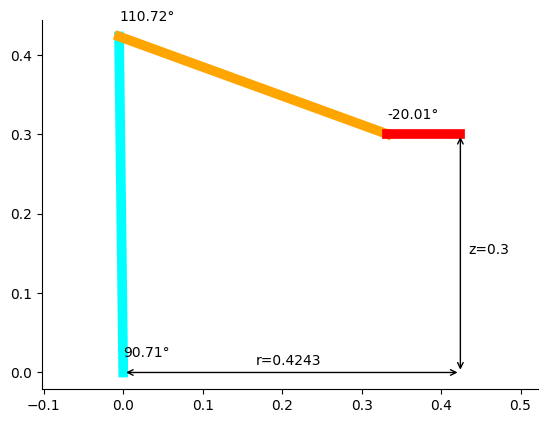

Target position (x,y,z): -0.3 -0.3 0.7
Angles (base, shoulder, elbow, wrist): [-135.0, 71.7346, 15.5104, 56.2242]
Robot Angles: [-135.0, -71.7346, 15.5104, -33.7758]
elbow (x,y): 0.133 0.402
wrist (x,y): 0.332 0.7
tool  (x,y): 0.424 0.7


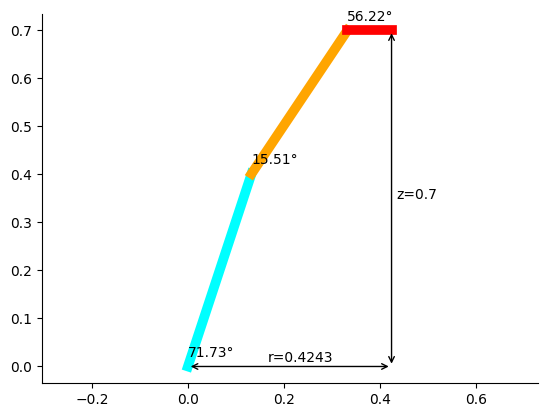

Target position (x,y,z): -0.3 0.4 0.2
Angles (base, shoulder, elbow, wrist): [126.8699, 74.2826, 109.5002, -35.2176]
Robot Angles: [126.8699, -74.2826, 109.5002, -125.2176]
elbow (x,y): 0.115 0.407
wrist (x,y): 0.408 0.2
tool  (x,y): 0.5 0.2


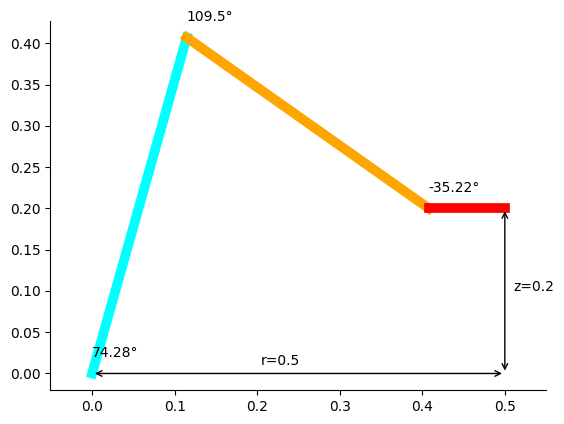

In [165]:
draw_arm(0.3, 0.3, 0.3)
draw_arm(-0.3, -0.3, 0.7)
draw_arm(-0.3, 0.4, 0.2)

## Interactive Arm

In [160]:
from ipywidgets import interact, FloatSlider

# Interactive slider for z coordinate
interact(draw_arm,  x=FloatSlider(min=0, max=1, step=0.01, value=0.3),
                    y=FloatSlider(min=0, max=1, step=0.01, value=0.3),
                    z=FloatSlider(min=0, max=1, step=0.01, value=0.3))


interactive(children=(FloatSlider(value=0.3, description='x', max=1.0, step=0.01), FloatSlider(value=0.3, desc…

<function __main__.draw_arm(x, y, z)>